# Windchime Demo

This notebook is a demo on how our windchime simulation/analysis is performed.

---------

### Initialization

This creates the detector and tracks to be used in the simulation.

In [1]:
import numpy as np
from scipy import stats

from planckmc.track_generation import halo_model
from planckmc.track_generation import make_tracks

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.mplot3d import Axes3D
import windchime as chime

from numba import njit
from tqdm import tqdm, trange

/home/cdyall01/.local/lib/python3.8/site-packages/wimprates/halo.py:143: RuntimeWarning: divide by zero encountered in true_divide
  (v_esc**2 - v_earth_t**2 - v**2)


In [15]:
'''
Just initializes some constants.
'''

## universal constants - https://pdg.lbl.gov/2021/web/viewer.html?file=%2F2020/reviews/rpp2020-rev-phys-constants.pdf
G = 6.64730e-11 #m^3/kg/s^2
amu = 1.6605390666e-29 #kg
k_B = 1.380649e-23 #J/K
GeV_per_c2 = 1.7826619218835431593e-27
mass_dm = 2.176434e-8 #kg https://en.wikipedia.org/wiki/Planck_units

In [16]:
'''
This is the detector initializer. It creates the cubic array to send the DM particles through.
'''

N_sensors_x = 101
N_sensors_y = 101
N_sensors_z = 101
length_x = 10 #metre
length_y = 10 #metre
length_z = 10 #metre

# This is the radius of the sphere that is used to parameterise tracks,
# as every track is parameterised by two points on a sphere.
# A radius that is smaller than the detector serves as a form of fiducialisation.
radius = 5 #metre

sensor_coords = np.zeros((3, N_sensors_x*N_sensors_y*N_sensors_z))
coords_1d = (
    np.linspace(-length_x/2, length_x/2, N_sensors_x),
    np.linspace(-length_y/2, length_y/2, N_sensors_y),
    np.linspace(-length_z/2, length_z/2, N_sensors_z),
)

x, y, z = np.meshgrid(*coords_1d, indexing='ij')

sensor_coords[0,:] = x.ravel()
sensor_coords[1,:] = y.ravel()
sensor_coords[2,:] = z.ravel()

sensor_vectors = np.repeat([[0,0,1]], sensor_coords.shape[1], axis=0).T #orientation vectors

sensor_mass = 1e-3 #kg
sensor_density = 1e4 #kg/m^3
min_impact_parameter = (sensor_mass/sensor_density)**(1/3) #metres
gas_pressure = 1e-10 #Pa

A_d = (sensor_mass/sensor_density)**(2/3) #sensor cross sectional area
beta = gas_pressure*A_d*np.sqrt(4*amu*k_B*4)/sensor_mass**2

In [17]:
''' 
Optional plot of the detector (not very useful for larger/denser arrays).
Uncomment to get the plot.
'''

# fig = plt.figure(figsize=(8, 6), dpi=100, tight_layout=True)
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(sensor_coords[0,:], sensor_coords[1,:], sensor_coords[2,:], s=1)
# plt.show()

' \nOptional plot of the detector (not very useful for larger/denser arrays).\nUncomment to get the plot.\n'

In [18]:
'''
This creates a given number N of random tracks.
'''

N = 1000 #Number of tracks

#generate array of velocities, sampled from the standard halo model
vel = halo_model.generate_vel_array(n_vels=N)
#generate 
entry_vecs, exit_vecs, t_entry, t_exit = make_tracks.generate_tracks(vel, np.zeros(vel.shape), radius=radius)

### Plot/Asserts to check the vector math

In [19]:
'''
Assert statements to check for correct shapes of these arrays.
'''

assert entry_vecs.shape == (3, N)
assert exit_vecs.shape == (3, N)
assert t_entry.shape == (N,)
assert t_exit.shape == (N,)

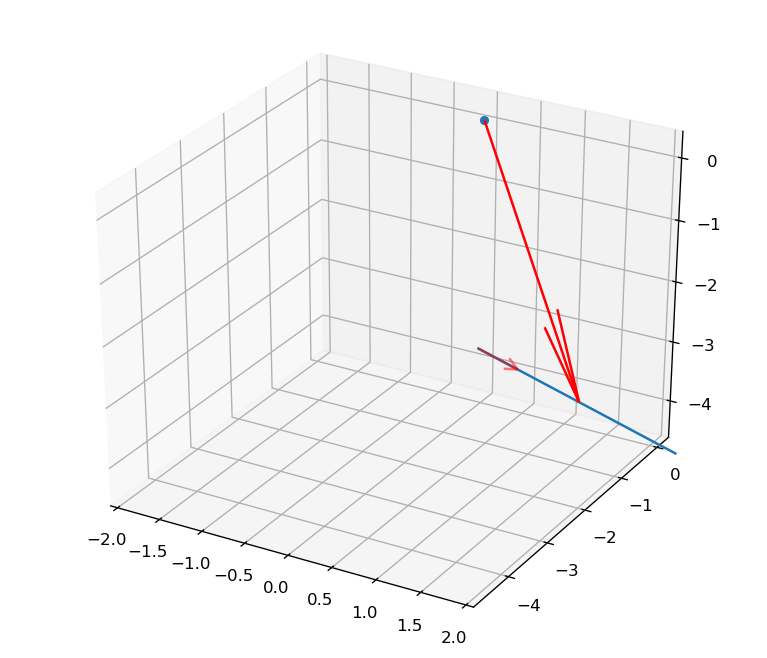

In [20]:
'''
Plot the image of a track vector, a sensor, and the b-vector (impact parameter) between the track and the sensor
'''
#Creates an array for sensor position and basis vector of the track
c = np.repeat(np.array([[0,0,.1]]),N,axis=0)
d = chime.find_basis_vectors(c.T,entry_vecs,exit_vecs)

#Checks shapes of the new arrays
assert np.linalg.norm(d[2], axis=0).shape == (N,)
assert np.repeat(np.array([[0,0,.1]]),N,axis=0).T.shape == (3, N)


fig = plt.figure(figsize=(8, 7), dpi=120)
ax = fig.add_subplot(111, projection='3d')

ax.plot(*np.concatenate(([entry_vecs[:,0]], [exit_vecs[:,0]]), axis=0).T)
ax.scatter(*c[0])
ax.quiver(*c[0], *(d[2][:,0]), color='red')
ax.quiver(*entry_vecs[:,0], *(d[1][:,0]), color='red', alpha=0.5)
ax.set(xlim=[-2,2])
plt.show()

In [ ]:
'''
More asserts to check that the vector math is correct.
'''

assert np.dot(d[2][:,0],d[1][:,0]) < 1e-15

sensor_orientation = np.repeat(np.array([[0,0,1]]),N,axis=0).T
signal_test = chime.signal(
    np.array([1]),
    np.array([1]),
    np.array([[0,0,1]]).T,
    np.array([[0,0,1]]).T,
    np.array([[0,0,1]]).T,
    mass=1, min_impact_parameter=min_impact_parameter
)

assert np.abs(G**2*np.pi/2 - signal_test[0]) < 1e-15

### Applying noise

The $\sigma_{noise}$ from [this note](https://github.com/windchimeproject/documentation_and_notes/blob/main/analysis_notes/Analytic_SNR_for_a_single_sensor.pdf) is related to $\alpha$ from [Dan et. al.'s paper](https://arxiv.org/abs/1903.00492) in this way:

$$m_{sensor}^2\frac{\sigma_{noise}^2}{\Delta t} = \alpha$$

as such, we can try to recreate plots from Dan's papers without worrying about the noise bandwidth.

below in the code, I will use the noise parameter $\beta=\frac{\alpha}{m_{sensor}^2}$.

From the above linked note where I calculated the SNR expression, it can be seen that the SNR with template matching is simply $\sqrt{\frac{S}{\beta}}$.

(Credit to Juehang Qin, 2021)

In [23]:
'''
Some variable renaming and creation of 7xN array of track_parameters.
'''

velocity = vel
position_entry = entry_vecs
position_exit = exit_vecs

track_parameters = np.vstack((velocity, position_entry, position_exit))
track_parameters.shape

(7, 1000)

In [24]:

sensor_positions = sensor_coords
sensor_positions.shape
sensor_positions

array([[-5. , -5. , -5. , ...,  5. ,  5. ,  5. ],
       [-5. , -5. , -5. , ...,  5. ,  5. ,  5. ],
       [-5. , -4.9, -4.8, ...,  4.8,  4.9,  5. ]])

In [25]:
track_parameters.T.shape

(1000, 7)

In [26]:
'''
Number of bins/binsize to be used for the simulation
'''
NUMBER_OF_BINS = 2000 # many bins, can always reduce
# np.log10(min_impact_parameter), np.log10(length_x)
BINS_B = np.logspace(np.log10(min_impact_parameter), np.log10(length_x), NUMBER_OF_BINS)
BINS_SNR = np.logspace(-5, 2, NUMBER_OF_BINS)

In [1]:
SNRhist, bhist, noisehist = chime.simulate(track_parameters, sensor_positions, beta=beta, bins_snr=BINS_SNR, bins_b=BINS_B)
print(SNRhist, bhist, noisehist)

NameError: name 'chime' is not defined